In [1]:
%matplotlib inline
import calendar
import time

import boto
import cartopy.crs as crs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import sklearn
from matplotlib import cm, colors
from sklearn import preprocessing
from sklearn.cross_decomposition import CCA


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
def read_data(init):
    years = ["2018", "2019", "2020", "2021"]
    savedir = "/home/aevans/ai2es/processed_data/frcst_err/"

    nam_fcast_and_error = []
    gfs_fcast_and_error = []
    hrrr_fcast_and_error = []

    for year in years:
        nam_fcast_and_error.append(
            pd.read_parquet(
                f"{savedir}nam_fcast_and_error_df_{init}z_{year}_mask_water_ny.parquet"
            )
        )
        gfs_fcast_and_error.append(
            pd.read_parquet(
                f"{savedir}gfs_fcast_and_error_df_{init}z_{year}_mask_water_ny.parquet"
            )
        )
        hrrr_fcast_and_error.append(
            pd.read_parquet(
                f"{savedir}hrrr_fcast_and_error_df_{init}z_{year}_mask_water_ny.parquet"
            )
        )

    nam_fcast_and_error_df = pd.concat(nam_fcast_and_error)
    gfs_fcast_and_error_df = pd.concat(gfs_fcast_and_error)
    hrrr_fcast_and_error_df = pd.concat(hrrr_fcast_and_error)

    # need to remove the random forecasts that have forecast hours 0
    # these are random because they only exist in the files that Ryan T. provided
    gfs_fcast_and_error_df = gfs_fcast_and_error_df[
        gfs_fcast_and_error_df["lead_time_ONLY_HOURS"] != 0.0
    ]
    nam_fcast_and_error_df = nam_fcast_and_error_df[
        nam_fcast_and_error_df["lead_time_ONLY_HOURS"] != 0.0
    ]
    hrrr_fcast_and_error_df = hrrr_fcast_and_error_df[
        hrrr_fcast_and_error_df["lead_time_ONLY_HOURS"] != 0.0
    ]
    return gfs_fcast_and_error_df, nam_fcast_and_error_df, hrrr_fcast_and_error_df

In [3]:
def format_df(df):
    df = df[df['lead_time_HOUR'] <= 18]
    error_months = (
            df.groupby([df.time.dt.month, "station"])[
                f"t2m_error"
            ]
            .mean()
        ).to_frame().reset_index()
    return error_months

In [4]:
def canonical(lulc):
    X = lulc.drop(columns='error')
    Y = lulc[['error']]
    X_mc = (X-X.mean())/(X.std())
    Y_mc = (Y-Y.mean())/(Y.std())
    ca = CCA(n_components=1)
    ca.fit(X_mc, Y_mc)
    X_c, Y_c = ca.transform(X_mc, Y_mc)
    cc_res = pd.DataFrame({"CCX_1":X_c[:, 0],
                       "CCY_1":Y_c[:, 0],
                       "11":lulc['11'].tolist(),
                       "21":lulc['21'].tolist(), 
                       "22":lulc['22'].tolist(), 
                       "23":lulc['23'].tolist(), 
                       "24":lulc['24'].tolist(), 
                       "31":lulc['31'].tolist(), 
                       "41":lulc['41'].tolist(), 
                       "42":lulc['42'].tolist(), 
                       "43":lulc['43'].tolist(), 
                       "52":lulc['52'].tolist(), 
                       "71":lulc['71'].tolist(), 
                       "81":lulc['81'].tolist(), 
                       "82":lulc['82'].tolist(), 
                       "90":lulc['90'].tolist(), 
                       "95":lulc['95'].tolist()})
    corr = np.corrcoef(X_c[:, 0], Y_c[:, 0])[0,1]
    return corr

In [5]:
def main(months_df, lulc):
    corr_ls = []
    for i in np.arange(1,13):
        df = months_df[months_df['time'] ==i]
        months = df['t2m_error'].to_list()
        lulc['error'] = months
        corr = canonical(lulc)
        corr_ls.append(corr)
    return corr_ls

In [6]:
def plot_heatmap(corr_ls):
    df = pd.DataFrame(corr_ls, index=np.arange(1,13))
    fig, ax = plt.subplots(figsize=(9,6))
    ax.set_title(f'Canonical Correlation Coefficients by Landtype')
    ax = sns.heatmap(df, vmin = 0, vmax = 1, cmap=cm.YlGnBu, annot = True)
    ax.set_ylabel('Month')
    ax.set_xlabel('Landtype')
    plt.tight_layout()

In [7]:
init = "12"

gfs_fcast_and_error_df, nam_fcast_and_error_df, hrrr_fcast_and_error_df = read_data(
    init
)
gfs_fcast_and_error_df = gfs_fcast_and_error_df.reset_index()
nam_fcast_and_error_df = nam_fcast_and_error_df.reset_index()
hrrr_fcast_and_error_df = hrrr_fcast_and_error_df.reset_index()

In [8]:
lulc = pd.read_csv('/home/aevans/nwp_bias/src/correlation/data/nlcd_gfs.csv')
lulc = lulc.drop(columns=['site', 'station'])
keys = lulc.keys()

# GFS

In [9]:
months_df = format_df(gfs_fcast_and_error_df)

In [10]:
corr_ls = main(months_df, lulc)

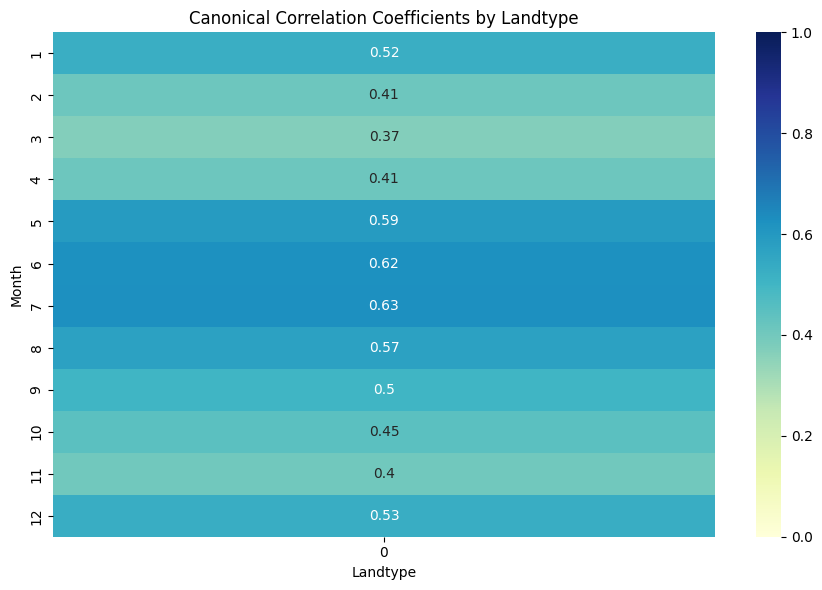

In [11]:
plot_heatmap(corr_ls)

In [12]:
# # Obtain the rotation matrices
# xrot = ca.x_rotations_
# yrot = ca.y_rotations_

# # Put them together in a numpy matrix
# xyrot = np.vstack((xrot,yrot))

# nvariables = xyrot.shape[0]

# plt.figure(figsize=(15, 15))
# plt.xlim((-1,1))
# plt.ylim((-1,1))

# # Plot an arrow and a text label for each variable
# for var_i in range(nvariables):
#   x = xyrot[var_i,0]
#   y = xyrot[var_i,1]

#   plt.arrow(0,0,x,y)
#   plt.text(x,y,data.columns[i], color='red' if i >= 6 else 'blue')

# plt.show()